In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
tf.keras.utils.set_random_seed(42)
np.random.seed(42)

In [3]:
def make_adding_problem(n_samples=8000, seq_len=100):
    # values: (n, T, 1)
    values = np.random.rand(n_samples, seq_len, 1).astype(np.float32)

    # markers: (n, T, 1) with exactly two 1s per sequence
    markers = np.zeros((n_samples, seq_len, 1), dtype=np.float32)

    for i in range(n_samples):
        idx = np.random.choice(seq_len, size=2, replace=False)
        markers[i, idx, 0] = 1.0

    # input: (n, T, 2)
    x = np.concatenate([values, markers], axis=-1)

    # target: sum of marked values => shape (n, 1)
    y = (values[:, :, 0] * markers[:, :, 0]).sum(axis=1, keepdims=True).astype(np.float32)

    return x, y

seq_len = 120
x_train, y_train = make_adding_problem(n_samples=12000, seq_len=seq_len)
x_val, y_val     = make_adding_problem(n_samples=2000,  seq_len=seq_len)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(12000).batch(128).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(256).prefetch(tf.data.AUTOTUNE)

In [4]:
def build_model(cell_type="gru", units=64, seq_len=120):
    inputs = tf.keras.Input(shape=(seq_len, 2))

    if cell_type == "rnn":
        x = tf.keras.layers.SimpleRNN(units)(inputs)
    elif cell_type == "lstm":
        x = tf.keras.layers.LSTM(units)(inputs)
    elif cell_type == "gru":
        x = tf.keras.layers.GRU(units)(inputs)
    else:
        raise ValueError("cell_type must be one of: rnn, lstm, gru")

    outputs = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
        loss="mse",
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model


Training: rnn
Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1873 - mae: 0.3512 - val_loss: 0.1646 - val_mae: 0.3292
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1709 - mae: 0.3384 - val_loss: 0.1668 - val_mae: 0.3303
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1704 - mae: 0.3381 - val_loss: 0.1681 - val_mae: 0.3321
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1701 - mae: 0.3367 - val_loss: 0.1727 - val_mae: 0.3397

Training: gru
Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.2632 - mae: 0.4084 - val_loss: 0.1698 - val_mae: 0.3338
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.1722 - mae: 0.3395 - val_loss: 0.1651 - val_mae: 0.3295
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.1694 - mae: 0.3369 - val_loss: 0.1636 - val_mae: 0.3280
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.1680 - mae: 0.3357 - val_loss: 0.1629 - val_mae: 0.3274
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━

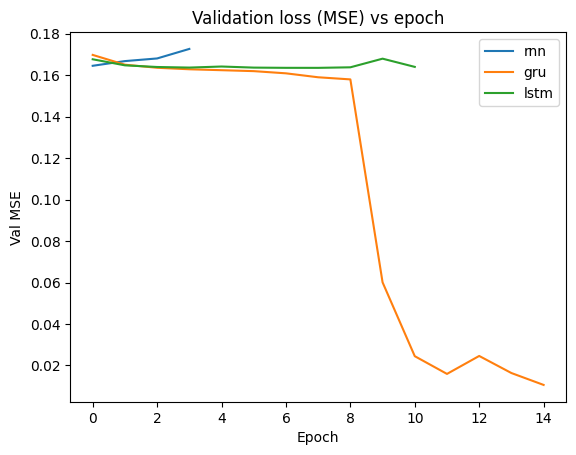

In [5]:
histories = {}

for cell in ["rnn", "gru", "lstm"]:
    print("\nTraining:", cell)
    model = build_model(cell_type=cell, units=64, seq_len=seq_len)

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    ]

    h = model.fit(train_ds, validation_data=val_ds, epochs=15, verbose=1, callbacks=callbacks)
    histories[cell] = (model, h.history)

# Plot validation loss
plt.figure()
for cell in ["rnn", "gru", "lstm"]:
    plt.plot(histories[cell][1]["val_loss"], label=cell)
plt.title("Validation loss (MSE) vs epoch")
plt.xlabel("Epoch")
plt.ylabel("Val MSE")
plt.legend()
plt.show()

In [6]:
x_test, y_test = make_adding_problem(n_samples=5, seq_len=seq_len)

for cell in ["rnn", "gru", "lstm"]:
    model = histories[cell][0]
    pred = model.predict(x_test, verbose=0).reshape(-1)
    print(cell, "pred:", np.round(pred, 3), "true:", np.round(y_test.reshape(-1), 3))

rnn pred: [0.986 0.983 1.014 1.006 1.008] true: [1.648 0.621 1.595 1.583 0.401]
gru pred: [1.687 0.676 1.534 1.625 0.581] true: [1.648 0.621 1.595 1.583 0.401]
lstm pred: [0.995 0.933 0.97  0.974 1.009] true: [1.648 0.621 1.595 1.583 0.401]
